In [56]:
import os
import time
import re
import string
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.preprocessing import LabelEncoder

import torch
from sentence_transformers import SentenceTransformer, util
import umap.umap_ as umap

from automl import AutoML

# define cache for sentencebert
os.environ['XDG_CACHE_HOME'] = 'home/msds2022/plarosa/ .cache'

/home/msds2022/plarosa/.local/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 6.28.-2017.03.24- is an invalid version and will not be supported in a future release
  warnings.warn(


### Extract Data

In [2]:
def get_abstract_data(db_path='../data/db.sqlite3'):
    """ outputs a dataframe with abstract and school_id
    
    Parameters
    ===========
    db_path      :      str
                        path of sqlite database
                        
    Returns
    ===========
    get_abstract_data    :   pandas.DataFrame
                             unique abstract and school_id
    """
    engine = create_engine('sqlite:///' + db_path)
    query = """
    SELECT rp.abstract,
           rp.school_id
    FROM research_profile rp
    WHERE rp.abstract IS NOT NULL
    AND rp.school_id IS NOT NULL
    GROUP BY rp.abstract, rp.school_id
    """
    with engine.connect() as conn:
        df = pd.read_sql(query, conn)

    return df

df = get_abstract_data()

### EDA

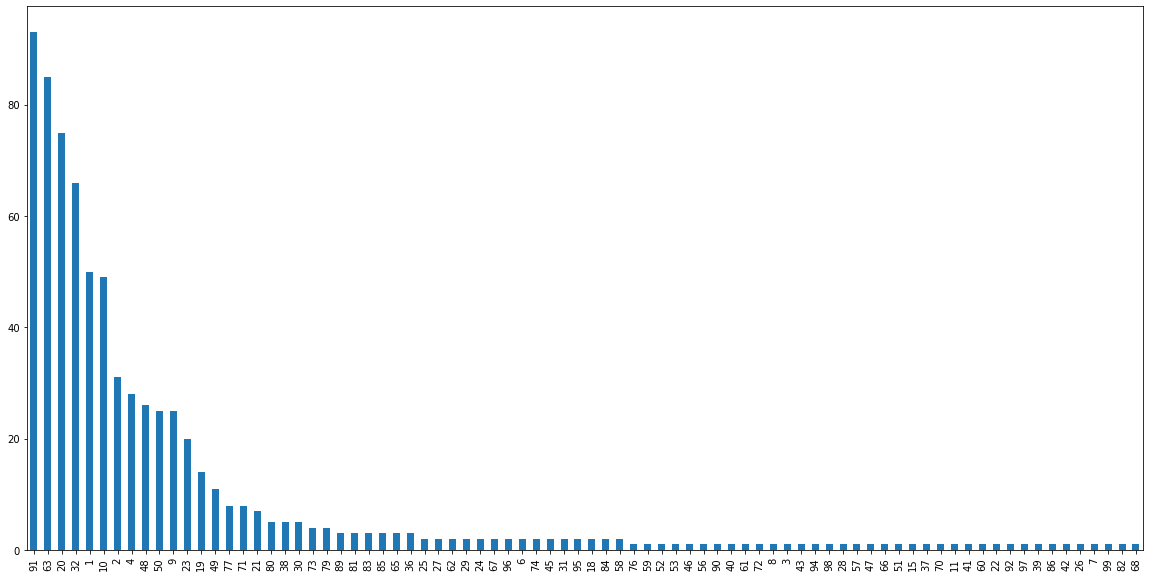

In [3]:
df.school_id.value_counts().plot.bar(figsize=(20,10));

Note:
- Highly imbalanced dataset
- Choose only schools with at least 20 research papers produced

In [4]:
school_count = df.school_id.value_counts()
top_schools = school_count[school_count > 20].index.tolist()

data = df[df.school_id.isin(top_schools)]

### Preprocess

In [5]:
# remove tagalog abstract - out of scope
data = data.drop([112, 167, 638, 648, 663])

In [6]:
# casefold abstract - because pretrained is uncased
# remove punctuations - does not add any meaning
data['abstract'] = (data.abstract.str.lower()
                        .str.replace('“', '', regex=False)
                        .str.replace(':', '', regex=False)
                        .str.replace('(', '', regex=False)
                        .str.replace(')', '', regex=False))

In [7]:
# remove outlier length
length = data.abstract.str.split(' ').apply(lambda x: np.log(len(x)))
data = data[abs((length - length.mean())/length.std()) < 3]

,abstract,school_id
1,a common goal for science educators is to enga...,10
3,a coupled parabolic-hyperbolic system of parti...,91
4,a food-based approach can be a more sustainabl...,10
5,a healthy alternative way of reducing the oil ...,48
6,a market survey on the production of ornamenta...,32
...,...,...
723,women play important roles in agricultural pro...,50
725,working with indigenous and local knowledge il...,91
726,wrasse labridae are one of the largest reef fi...,32
727,he chapter reviews and examines water-related ...,91


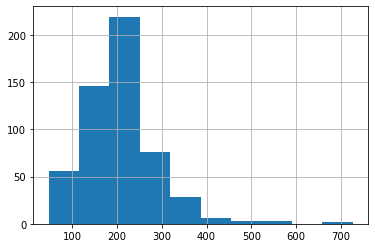

In [8]:
# check histogram after preprocessing
data.abstract.str.split(' ').apply(lambda x: len(x)).hist();

In [9]:
# load sentence transformer model
model = SentenceTransformer('allenai/scibert_scivocab_uncased')
model.max_seq_length = 512

Some weights of the model checkpoint at home/msds2022/plarosa/ .cache/torch/sentence_transformers/allenai_scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
# encode abstract using pretrained model
start_time = time.time()
embeddings = model.encode(data.abstract.tolist(), convert_to_tensor=True)
end_time = time.time()
print("Time for computing embeddings:", str(end_time - start_time))

Time for computing embeddings: 854.2845995426178


### Model Training 

#### Baseline Models

In [65]:
X = pd.DataFrame(embeddings.cpu().numpy())
y = data.reset_index(drop=True)['school_id']

le = LabelEncoder()
y = le.fit_transform(y)


In [66]:
counts = pd.Series(y).value_counts()
pcc = (counts / counts.sum()) ** 2
pcc = pcc.sum() * 1.25
print("Proportional Chance Criterion (PCC): ", pcc)

Proportional Chance Criterion (PCC):  0.14014907700303936


In [68]:
C = [1e-5, 1e-4, 1e-3, .01, 0.1, 10, 100, 1000, 10000]
n_neighbors = list(range(1, 51))
max_depth = list(range(1, 11))

automl_tree = AutoML(['dtc', 'rfc'])
splits = automl_tree.split_data(X, y, shuffle=True, 
                                num_trials=10, stratify=True, 
                                test_size=0.25)
automl_tree.train_model(X, y, 
                        param_grid={'max_depth':max_depth})
tree_summary = automl_tree.generate_summary()

automl_linear_l1 = AutoML(['log', 'svl'])
splits = automl_linear_l1.split_data(X, y, shuffle=True, 
                                     num_trials=20, stratify=True,
                                     test_size=0.25)
automl_linear_l1.train_model(X, y, param_grid= {'C' : C}, 
                        fixed_params={'penalty' : 'l1'})
linearl1_summary = automl_linear_l1.generate_summary()

automl_linear_l2 = AutoML(['log', 'svl'])
splits = automl_linear_l2.split_data(X, y, shuffle=True, 
                                     num_trials=20, stratify=True, 
                                     test_size=0.25)
automl_linear_l2.train_model(X, y, param_grid= {'C' : C}, 
                        fixed_params={'penalty' : 'l2'})
linearl2_summary = automl_linear_l2.generate_summary()

automl_knc = AutoML('knc')
splits = automl_knc.split_data(X, y, num_trials=5, stratify=True, 
                               test_size=0.25, 
                               shuffle=True)
automl_knc.train_model(X, y, param_grid={'n_neighbors' : range(1,5)})
knc_summary = automl_knc.generate_summary()


df1 = pd.concat([tree_summary, 
                linearl1_summary, 
                linearl2_summary]).reset_index(drop=True)
knc_summary = pd.Series(knc_summary, index=df.columns)
df1.loc[len(df)] = knc_summary
display(df1)

,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable,Run Time
0,Decision Tree,0.264444,max_depth = 8,720,16.083670
1,Random Forest,0.386667,max_depth = 10,720,31.768171
2,Logistic Regression (l1),0.475556,C = 1000,369,85.246725
3,Linear SVM (l1),0.457778,C = 100,373,596.327696
4,Logistic Regression (l2),0.473333,C = 10,422,296.802040
5,Linear SVM (l2),0.489259,C = 0.1,422,252.586126
7,knn Classification,0.503704,n_neighbors = 1,NA,7.435286


Notes:
- Models took time to train
- Mostly overfitting

#### With Dimensionality Reduction

In [57]:
umap_embeddings = umap.UMAP(n_neighbors=20, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings.cpu())

In [60]:
X = pd.DataFrame(umap_embeddings)

In [64]:
C = [1e-5, 1e-4, 1e-3, .01, 0.1, 10, 100, 1000, 10000]
n_neighbors = list(range(1, 51))
max_depth = list(range(1, 11))

automl_tree = AutoML(['dtc', 'rfc'])
splits = automl_tree.split_data(X, y, shuffle=True, 
                                num_trials=10, stratify=True, 
                                test_size=0.25)
automl_tree.train_model(X, y, 
                        param_grid={'max_depth':max_depth})
tree_summary = automl_tree.generate_summary()

automl_linear_l1 = AutoML(['log', 'svl'])
splits = automl_linear_l1.split_data(X, y, shuffle=True, 
                                     num_trials=20, stratify=True,
                                     test_size=0.25)
automl_linear_l1.train_model(X, y, param_grid= {'C' : C}, 
                        fixed_params={'penalty' : 'l1'})
linearl1_summary = automl_linear_l1.generate_summary()

automl_linear_l2 = AutoML(['log', 'svl'])
splits = automl_linear_l2.split_data(X, y, shuffle=True, 
                                     num_trials=20, stratify=True, 
                                     test_size=0.25)
automl_linear_l2.train_model(X, y, param_grid= {'C' : C}, 
                        fixed_params={'penalty' : 'l2'})
linearl2_summary = automl_linear_l2.generate_summary()

automl_knc = AutoML('knc')
splits = automl_knc.split_data(X, y, num_trials=5, stratify=True, 
                               test_size=0.25, 
                               shuffle=True)
automl_knc.train_model(X, y, param_grid={'n_neighbors' : range(1,5)})
knc_summary = automl_knc.generate_summary()


df2 = pd.concat([tree_summary, 
                linearl1_summary, 
                linearl2_summary]).reset_index(drop=True)
knc_summary = pd.Series(knc_summary, index=df.columns)
df.loc[len(df2)] = knc_summary
display(df2)

,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable,Run Time
0,Decision Tree,0.350370,max_depth = 10,4,0.519581
1,Random Forest,0.420741,max_depth = 8,4,32.062812
2,Logistic Regression (l1),0.324815,C = 1000,1,27.435448
3,Linear SVM (l1),0.284444,C = 1000,2,7.156026
4,Logistic Regression (l2),0.303333,C = 1000,4,8.547466
5,Linear SVM (l2),0.276667,C = 0.1,2,15.161127
6,knn Classification,0.440000,n_neighbors = 1,NA,0.340769


Notes:
- Speed improve
- Accuracy decrease

### Evaluation

In [95]:
(X_train, X_test, 
 y_train, y_test) = train_test_split(X, y,
                                    test_size=0.25,
                                    random_state=143, 
                                    shuffle=True,
                                    stratify=y)

model = LinearSVC(C=0.1)
model.fit(X_train, y_train);

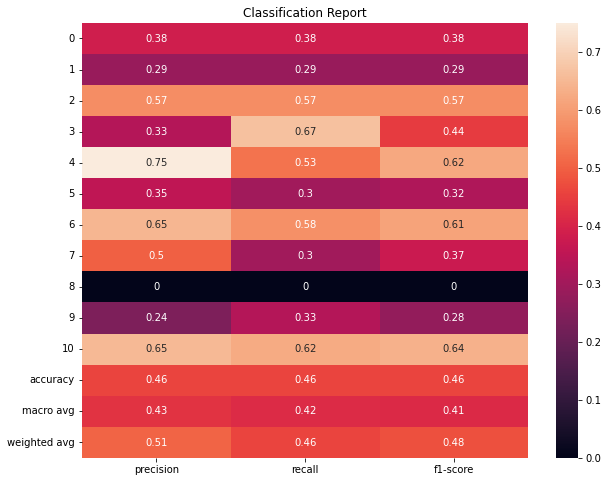

In [92]:
plt.figure(figsize=(10, 8))
clf_report = classification_report(model.predict(X_test), 
                                   y_test,
                                   output_dict=True, 
                                   zero_division=0)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.title('Classification Report');

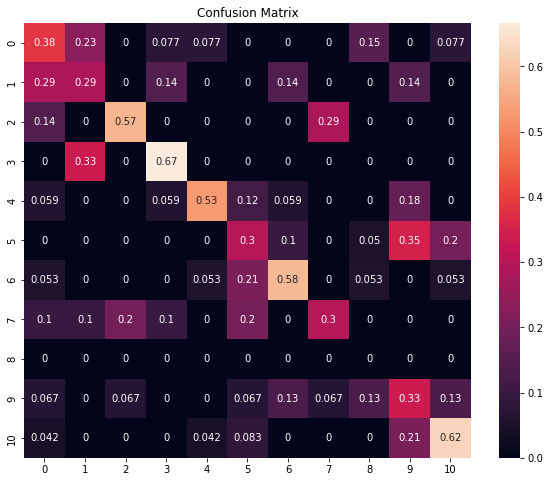

In [93]:
plt.figure(figsize=(10, 8))
cf_matrix = confusion_matrix(model.predict(X_test), y_test,
                            normalize='true')
sns.heatmap(cf_matrix, annot=True)
plt.title('Confusion Matrix');